In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

## №1. Загрузите датасет Dirty Café Sales из CSV-файла в датафрейм Pandas.

Датасет содержит данные о покупках посетителей кафе за некоторый период.

Описание полей датасета:

Transaction ID — уникальный идентификатор транзакции (покупки);

Item — наименование товара;

Quantity — количество купленных единиц товара;

Price Per Unit — стоимость одной единицы товара;

Total Spent — сумма покупки;

Payment Method — способ оплаты;

Location — место проведения транзакции;

Transaction Date — дата покупки.

In [2]:
sales = pd.read_csv('data/Dirty_Café_Sales.csv')
sales.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1000555,Tea,1,1.5,1.5,Credit Card,In-store,2023-10-19
1,TXN_1001832,Salad,2,5.0,10.0,Cash,Takeaway,2023-05-23
2,TXN_1002457,Cookie,5,1.0,5.0,Digital Wallet,Takeaway,2023-09-29
3,TXN_1003246,Juice,2,3.0,6.0,NaN,NaN,2023-02-15
4,TXN_1004184,Smoothie,1,4.0,4.0,Credit Card,In-store,2023-05-18


In [3]:
# посмотрим общую информацию о датасете 
# уже видим, что есть пропуски во всех столбцах, кроме первого и последнего
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10048 entries, 0 to 10047
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10048 non-null  object
 1   Item              9711 non-null   object
 2   Quantity          9910 non-null   object
 3   Price Per Unit    9869 non-null   object
 4   Total Spent       9875 non-null   object
 5   Payment Method    7454 non-null   object
 6   Location          6771 non-null   object
 7   Transaction Date  10048 non-null  object
dtypes: object(8)
memory usage: 628.1+ KB


## №2. Есть ли в датасете дубли? Если да, то избавьтесь от них средствами Python.

In [4]:
# посмотрим есть ли хоть один дубликат
sales.duplicated().any()

np.True_

In [5]:
sales['Transaction ID'].nunique() == sales.shape[0]

False

Дубликаты присутствуют.

In [6]:
# сперва найдем число дубликатов
mask = sales.duplicated()
sales_duplicates = sales[mask]
print(f'Число найденных дубликатов: {sales_duplicates.shape[0]}')


Число найденных дубликатов: 48


In [7]:
# потом удалим их из датасета
sales = sales.drop_duplicates()
print(f'Результирующее число записей: {sales.shape[0]}')

Результирующее число записей: 10000


## №3. Исследуйте датасет на наличие пропусков и/или некорректных значений. Каков их процент для каждого из столбцов? Каков процент полностью корректных строк?

In [8]:
# выведем процент пропусков по каждому из столбцов
cols_null_percent = sales.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null
# больше всего информации пропущено в столбцах Location, Payment Method

Location          32.65
Payment Method    25.79
Item               3.33
Price Per Unit     1.79
Total Spent        1.73
Quantity           1.38
dtype: float64

In [9]:
# процент без пропусков
for i in sales:
    cols_without_null  = 100 - cols_null_percent

cols_without_null

Transaction ID      100.00
Item                 96.67
Quantity             98.62
Price Per Unit       98.21
Total Spent          98.27
Payment Method       74.21
Location             67.35
Transaction Date    100.00
dtype: float64

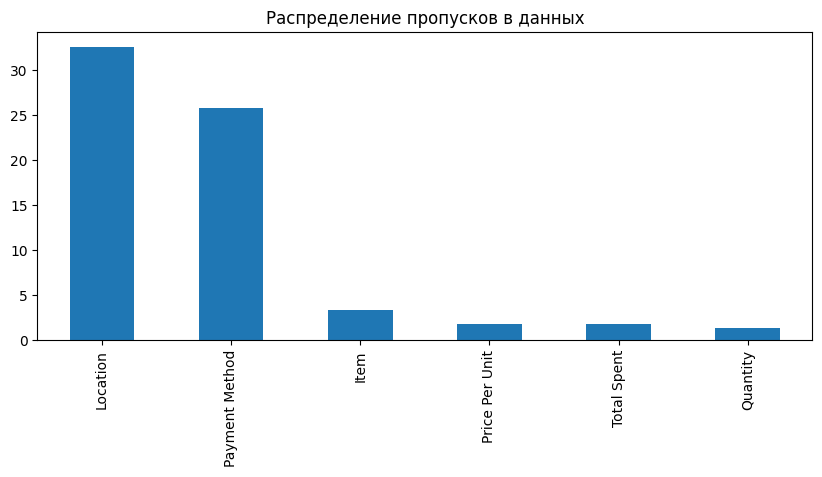

In [10]:
# отобразим соотношение пропусков на графике
cols_with_null.plot(
    kind='bar', 
    figsize=(10,4),
    title='Распределение пропусков в данных'
);

In [11]:
# посмотрим неинформативные признаки (много уникальных или много одинаковых)
low_information_cols = [] 

#цикл по всем столбцам
for col in sales.columns:
    #наибольшая относительная частота в признаке
    top_freq = sales[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = sales[col].nunique() / sales[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

Transaction ID: 100.0% уникальных значений


## №4. Придумайте способ заполнить пропуски в числовых столбцах Quantity, Price Per Unit, Total Spent. Можно ли восстановить точные значения на основе имеющихся данных? Напишите код, реализующий ваш алгоритм.

In [12]:
# все значения в таблице - типа object; нужно перевести столбцы Quantity, Price Per Unit, Total Spent в числовые
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 10047
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  10000 non-null  object
dtypes: object(8)
memory usage: 703.1+ KB


In [13]:
# также заменим значения ERROR, UNKNOWN на np.nan для их дальнейшей обработки
sales.replace(['ERROR', 'UNKNOWN'], np.nan, inplace=True)

In [14]:
sales['Quantity'] = pd.to_numeric(sales['Quantity'], downcast='float')
sales['Price Per Unit'] = pd.to_numeric(sales['Price Per Unit'], downcast='float')
sales['Total Spent'] = pd.to_numeric(sales['Total Spent'],downcast='float')
# теперь три числовых столбца типа float
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 10047
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              9031 non-null   object 
 2   Quantity          9521 non-null   float32
 3   Price Per Unit    9467 non-null   float32
 4   Total Spent       9498 non-null   float32
 5   Payment Method    6822 non-null   object 
 6   Location          6039 non-null   object 
 7   Transaction Date  10000 non-null  object 
dtypes: float32(3), object(5)
memory usage: 585.9+ KB


Пропущенные числовые значения можно восстановить в точности - если неизвестно количество купленных продуктов, делим итоговую стоимость на цену за единицу товара. Если неизвестна итоговая стоимость, умножаем количество на цену за единицу. И так далее.

In [15]:
# напишем функцию для заполнения пропусков на основании данных из соседних столбцов
def fill_missing_values(row):
    # если пропущено количество продуктов
    if pd.isna(row['Quantity']) and not pd.isna(row['Total Spent']) and not pd.isna(row['Price Per Unit']):
        row['Quantity'] = row['Total Spent'] / row['Price Per Unit']
    
    # если пропущена стоимость за единицу продукта
    elif pd.isna(row['Price Per Unit']) and not pd.isna(row['Total Spent']) and not pd.isna(row['Quantity']):
        row['Price Per Unit'] = row['Total Spent'] / row['Quantity']

    
    # если пропущена стоимость итоговая
    elif pd.isna(row['Total Spent']) and not pd.isna(row['Quantity']) and not pd.isna(row['Price Per Unit']):
        row['Total Spent'] = row['Quantity'] * row['Price Per Unit']
    
    return row

# применяем функцию ко всем строкам DataFrame
sales = sales.apply(fill_missing_values, axis=1)
sales.sample(10)


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
1844,TXN_2580487,Cake,1.0,3.0,3.0,NaN,Takeaway,2023-01-13
3506,TXN_4084548,Salad,2.0,5.0,10.0,Cash,In-store,2023-07-21
1064,TXN_1946773,Sandwich,4.0,4.0,16.0,Cash,NaN,2023-08-28
5714,TXN_6070523,NaN,4.0,2.0,8.0,Cash,NaN,2023-04-11
6931,TXN_7171303,Sandwich,1.0,4.0,4.0,NaN,NaN,2023-04-30
4868,TXN_5326795,Cookie,2.0,1.0,2.0,NaN,NaN,2023-04-05
8947,TXN_8991609,Salad,4.0,5.0,20.0,Digital Wallet,In-store,2023-06-19
1944,TXN_2670824,Juice,2.0,3.0,6.0,Digital Wallet,Takeaway,2023-03-03
7762,TXN_7916758,Smoothie,1.0,4.0,4.0,NaN,Takeaway,2023-10-14
5522,TXN_5908362,Sandwich,5.0,4.0,20.0,Digital Wallet,NaN,2023-10-03


In [16]:
# посмотрим кол-во пропусков
cols_null_percent = sales.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null
# видим, что кол-во пропусков по трем нижних столбцам (которые мы обрабатывали) снизилось примерно в 4 раза

Location          39.61
Payment Method    31.78
Item               9.69
Total Spent        0.40
Quantity           0.38
Price Per Unit     0.38
dtype: float64

Пропуски по трем столбцам остались в небольшом количестве в тех строках, где из трех значений нет двух и достоверно их заполнить не представляется возможным. Заполнять же средним/медианным значением не имеет смысла, так как может дать ложные результаты при анализе. Поэтому возможно есть вариант удалить строки, где два пропуска и больше. С другой стороны, если эти данные для нас очень важны, можно уделить еще время и составить словарь {Продукт: Цена за продукт} и в соответствии с этим расставлять вместо пропусков на месте Price Per Unit цену из этого словаря. 

In [17]:
sales[sales['Total Spent'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
294,TXN_1259340,Tea,3.0,NaN,NaN,Digital Wallet,NaN,2023-02-24
584,TXN_1525583,Sandwich,3.0,NaN,NaN,Cash,Takeaway,2023-05-20
604,TXN_1547245,Sandwich,NaN,4.0,NaN,NaN,Takeaway,2023-09-11
1098,TXN_1975184,Coffee,NaN,2.0,NaN,Digital Wallet,NaN,2023-01-15
1168,TXN_2023651,Sandwich,NaN,4.0,NaN,Cash,In-store,2023-05-25
1456,TXN_2253622,Sandwich,5.0,NaN,NaN,Digital Wallet,Takeaway,2023-09-30
1658,TXN_2428781,Salad,NaN,5.0,NaN,NaN,In-store,2023-05-09
1801,TXN_2546684,Juice,NaN,3.0,NaN,Digital Wallet,Takeaway,2023-04-08
2126,TXN_2857444,Smoothie,1.0,NaN,NaN,Cash,Takeaway,2023-05-10
2264,TXN_2962976,Juice,NaN,3.0,NaN,NaN,NaN,2023-03-17


## №5. Исследуйте полноту категориальных столбцов Payment Method, Location. Можно ли извлечь из них полезную информацию обо всей выборке? Какие есть варианты исправления заполненности этих столбцов? Какие риски и преимущества несет каждый из них?

In [18]:
# повторно выведем процент пропусков по этим столбцам
sales[['Payment Method', 'Location']].isnull().mean()*100

Payment Method    31.78
Location          39.61
dtype: float64

In [19]:
# проверим уникальные значения
sales['Payment Method'].unique()

array(['Credit Card', 'Cash', 'Digital Wallet', nan], dtype=object)

In [20]:
sales['Location'].unique()

array(['In-store', 'Takeaway', nan], dtype=object)

In [21]:
# исследуем частоту категорий 
sales['Payment Method'].value_counts()

Payment Method
Digital Wallet    2291
Credit Card       2273
Cash              2258
Name: count, dtype: int64

In [22]:
sales['Location'].value_counts()

Location
Takeaway    3022
In-store    3017
Name: count, dtype: int64

Значения в столбцах Payment Method и Location являются категориальными и говорят нам о способе оплаты (Digital Wallet, Cash, Credit Card) и о месте(In-store, Takeaway), соответственно. 

Мы видим из общей статистики по пропускам, что в этих столбцах наибольшее количество пропусков - в столбце Location 39.61 %, а в Payment Method - 31.78 %, что довольно много.

Варианты исправить ситуацию: 1.Заполнить пропуски модальными значениями. Но в нашей ситуации распределение значений практически одинаково, и мы не можем поставить во всех пропусках по столбцу Location, например, значение Takeaway только потому, что оно встречаемся на 5 строк чаще. Поэтому более резонно здесь будет поделить распределение значений поровну в пропусках. Как в столбце Payment Method, так и в Location. Этот вариант, разумеется не является точным заполнением и есть риски, что это негативным образом повлияет на интерпретацию результатов. Однако это лучше, чем удалить два этих столбца (это второй вариант работы с пропусками), так как они являются достаточно ценными для анализа.

In [23]:
# реализуем подход
# создадим функцию, которая будем принимать датасет, столбец и категории в нем
def fill_categories_equally(df, column, categories):
    # определяем количество пропусков в столбце
    missing_count = df[column].isna().sum()
    
    if missing_count > 0:
        # разбиваем количество пропусков на части, соответствующие числу категорий
        repetitions = missing_count // len(categories)
        remainder = missing_count % len(categories)

        # создаем список категорий с равномерным распределением
        filled_values = categories * repetitions + categories[:remainder]

        # перемешиваем заполненные значения для случайного распределения
        np.random.shuffle(filled_values)

        # заполняем пропуски
        df.loc[df[column].isna(), column] = filled_values

    return df

# категории для столбца Payment Method
payment_categories = ['Cash', 'Credit Card', 'Digital Wallet']
# категории для столбца Location
location_categories = ['Takeaway', 'In-store']

# Заполняем пропуски равномерно по каждому столбцу
sales = fill_categories_equally(sales, 'Payment Method', payment_categories)
sales = fill_categories_equally(sales, 'Location', location_categories)

sales.isnull().mean()*100


Transaction ID      0.00
Item                9.69
Quantity            0.38
Price Per Unit      0.38
Total Spent         0.40
Payment Method      0.00
Location            0.00
Transaction Date    0.00
dtype: float64

Видим, что теперь пропусков по столбцам Payment Method и Location нет, а распределение категорий по каждому столбцу такое же равномерное (см.ниже)

In [24]:
sales['Payment Method'].value_counts()

Payment Method
Digital Wallet    3350
Credit Card       3332
Cash              3318
Name: count, dtype: int64

In [25]:
sales['Location'].value_counts()

Location
Takeaway    5003
In-store    4997
Name: count, dtype: int64

## №6. Установите на локальную машину сервер PostgreSQL и загрузите в него датасет autos (например, с помощью программы DBeaver). Напишите скрипт, который выгружает датасет из таблицы PostgreSQL в датафрейм.

In [26]:

# параметры подключения
dbname = "postgres"
user = "postgres" # укажите логин, указанный при установке PostgreSQL сервера
password = "1904" # и пароль
host = "localhost"
port = "5432"

# подключение к базе данных
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)

# поздание курсора
cursor = conn.cursor()

# выполнение SQL-запроса для получения данных из таблицы
sql = "SELECT * FROM autos"
cursor.execute(sql)

# извлечение данных и преобразование в датафрейм
df = pd.DataFrame(cursor.fetchall())
columns = [desc[0] for desc in cursor.description]
df.columns = columns

# закрытие курсора и подключения
cursor.close()
conn.close()

# вывод датафрейма
display(df)

,datecrawled,name,seller,offertype,price,vehicletype,yearofregistration,gearbox,powerps,model,odometer,monthofregistration,fueltype,brand,notrepaireddamage,nrofpictures,postalcode,lastseen
0,2016-03-26 17:47:46,Peugeot_807_160_NAVTECH_ON_BOARD,privat,Angebot,"$5,000",bus,2004,manuell,158,andere,"150,000km",3,lpg,peugeot,nein,0,79588,2016-04-06 06:45:54
1,2016-04-04 13:38:56,BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik,privat,Angebot,"$8,500",limousine,1997,automatik,286,7er,"150,000km",6,benzin,bmw,nein,0,71034,2016-04-06 14:45:08
2,2016-03-26 18:57:24,Volkswagen_Golf_1.6_United,privat,Angebot,"$8,990",limousine,2009,manuell,102,golf,"70,000km",7,benzin,volkswagen,nein,0,35394,2016-04-06 20:15:37
3,2016-03-12 16:58:10,Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...,privat,Angebot,"$4,350",kleinwagen,2007,automatik,71,fortwo,"70,000km",6,benzin,smart,nein,0,33729,2016-03-15 03:16:28
4,2016-04-01 14:38:50,Ford_Focus_1_6_Benzin_TЬV_neu_ist_sehr_gepfleg...,privat,Angebot,"$1,350",kombi,2003,manuell,0,focus,"150,000km",7,benzin,ford,nein,0,39218,2016-04-01 14:38:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2016-03-27 14:38:19,Audi_Q5_3.0_TDI_qu._S_tr.__Navi__Panorama__Xenon,privat,Angebot,"$24,900",limousine,2011,automatik,239,q5,"100,000km",1,diesel,audi,nein,0,82131,2016-04-01 13:47:40
49996,2016-03-28 10:50:25,Opel_Astra_F_Cabrio_Bertone_Edition___TЬV_neu+...,privat,Angebot,"$1,980",cabrio,1996,manuell,75,astra,"150,000km",5,benzin,opel,nein,0,44807,2016-04-02 14:18:02
49997,2016-04-02 14:44:48,Fiat_500_C_1.2_Dualogic_Lounge,privat,Angebot,"$13,200",cabrio,2014,automatik,69,500,"5,000km",11,benzin,fiat,nein,0,73430,2016-04-04 11:47:27
49998,2016-03-08 19:25:42,Audi_A3_2.0_TDI_Sportback_Ambition,privat,Angebot,"$22,900",kombi,2013,manuell,150,a3,"40,000km",11,diesel,audi,nein,0,35683,2016-04-05 16:45:07


Датасет содержит список объявлений для сайта о продаже подержанных автомобилей

Описание полей датасета:

dateCrawled — дата размещения объявления;

name — заголовок объявления;

seller — тип продавца;

offerType — тип предложения;

price — стоимость в USD;

vehicleType — тип транспортного средства;

yearOfRegistration — год регистрации транспортного средства;

gearbox — тип коробки передач;

powerPS — мощность двигателя;

model — модель;

odometer — пробег;

monthOfRegistration — месяц регистрации транспортного средства;

fuelType — тип топлива;

brand — бренд;

notRepairedDamage — требует ли ремонта?;

nrOfPictures — количество загруженных фотографий;

postalCode — почтовый индекс продавца;

lastSeen — дата последнего просмотра объявления.

### №7. Исследуйте датасет. Какие признаки являются неинформативными для задач изучения рынка подержанных автомобилей? Что с ними делать? Исправьте датафрейм.

In [27]:
# проверим на наличие дубликатов в таблице
df.duplicated().any()

np.False_

В таблице отсутствуют дубликаты

In [28]:
# и отдельно по столбцу с датой размещения объявления
df['datecrawled'].duplicated().any()

np.True_

Есть одинаковые даты размещения объявления (datecrawled), что связано вероятно с размещением нескольких разных объявлений в один день.

In [29]:
# посмотрим на информацию о датасете (кол-ве пропусков и типе данных)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   datecrawled          50000 non-null  object
 1   name                 50000 non-null  object
 2   seller               50000 non-null  object
 3   offertype            50000 non-null  object
 4   price                50000 non-null  object
 5   vehicletype          50000 non-null  object
 6   yearofregistration   50000 non-null  int64 
 7   gearbox              50000 non-null  object
 8   powerps              50000 non-null  int64 
 9   model                50000 non-null  object
 10  odometer             50000 non-null  object
 11  monthofregistration  50000 non-null  int64 
 12  fueltype             50000 non-null  object
 13  brand                50000 non-null  object
 14  notrepaireddamage    50000 non-null  object
 15  nrofpictures         50000 non-null  int64 
 16  post

В таблице отсутствуют пропуски

In [30]:
# перед дальнейшими изменениями скопируем таблицу
df_c = df.copy()

In [31]:
# исследуем неинформативные признаки, а именно те, в которых >95% значений одинаковые или, наоборот, уникальные

low_information = [] 

# цикл по всем столбцам
for col in df_c.columns:
    # наибольшая относительная частота в признаке
    top_freq = df_c[col].value_counts(normalize=True).max()
    # доля уникальных значений от размера признака
    nunique_ratio = df_c[col].nunique() / df_c[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

datecrawled: 96.43% уникальных значений
seller: 100.0% одинаковых значений
offertype: 100.0% одинаковых значений
nrofpictures: 100.0% одинаковых значений


Столбцы seller, offertype, nrofpictures подлежат удалению в связи с большим процентом (а именно 100%) уникальных значений. Удаление этих столбцов не принесет ущерба для дальнейшего анализа данных. Также удалим столбец datecrawled, так как 96.43% уникальных значений + дата размещения объявления не влияет на цену выставляемого на продажу автомобиля.  

Помимо прочего я бы удалила такие признаки, как name, monthofregistration, lastseen и postalcode, так как они не несут значимой информации для анализа рынка подержанных автомобилей. Name повторяет информацию из столбцов brand, model и fueltype (их мы оставим), а monthofregistration, lastseen и postalcode просто не несут никакой информации о важных взаимосвязей.

In [32]:
more = ['monthofregistration', 'name', 'lastseen', 'postalcode']
low_information.extend(more)

df_c = df_c.drop(low_information, axis=1)


In [33]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               50000 non-null  object
 1   vehicletype         50000 non-null  object
 2   yearofregistration  50000 non-null  int64 
 3   gearbox             50000 non-null  object
 4   powerps             50000 non-null  int64 
 5   model               50000 non-null  object
 6   odometer            50000 non-null  object
 7   fueltype            50000 non-null  object
 8   brand               50000 non-null  object
 9   notrepaireddamage   50000 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.8+ MB


Удалив 8 неинформативных столбцов, мы получили на выходе 10 и 50.000 непустых и недублированных строк.

### №8. Найдите выбросы в различных столбцах. Что с ними делать? Исправьте датафрейм.
### №9. Продемонстрируйте визуально, что выбросов не осталось.

In [34]:
df_c.head()

,price,vehicletype,yearofregistration,gearbox,powerps,model,odometer,fueltype,brand,notrepaireddamage
0,"$5,000",bus,2004,manuell,158,andere,"150,000km",lpg,peugeot,nein
1,"$8,500",limousine,1997,automatik,286,7er,"150,000km",benzin,bmw,nein
2,"$8,990",limousine,2009,manuell,102,golf,"70,000km",benzin,volkswagen,nein
3,"$4,350",kleinwagen,2007,automatik,71,fortwo,"70,000km",benzin,smart,nein
4,"$1,350",kombi,2003,manuell,0,focus,"150,000km",benzin,ford,nein


Попробуем поискать выбросы в данных с помощью метода межквартильного размаха (метода Тьюки). Он сработает только для числовых данных, поэтому столбцы price, odometer нужно будет перевести из object в float.

In [35]:
# cнова копируем таблицу
df_2 = df_c.copy()
# избавляемся от знаков, которые не относятся к цифрам
df_2['price'] = df_2['price'].str.replace(r'\D', '', regex = True)
# сразу переводим данные от строковых к вещественным
df_2['price'] = df_2['price'].astype(float)
df_2.head()

,price,vehicletype,yearofregistration,gearbox,powerps,model,odometer,fueltype,brand,notrepaireddamage
0,5000.0,bus,2004,manuell,158,andere,"150,000km",lpg,peugeot,nein
1,8500.0,limousine,1997,automatik,286,7er,"150,000km",benzin,bmw,nein
2,8990.0,limousine,2009,manuell,102,golf,"70,000km",benzin,volkswagen,nein
3,4350.0,kleinwagen,2007,automatik,71,fortwo,"70,000km",benzin,smart,nein
4,1350.0,kombi,2003,manuell,0,focus,"150,000km",benzin,ford,nein


In [36]:
# аналогично поступаем со столбцом odometer
df_2['odometer'] = df_2['odometer'].str.replace(r'\D', '', regex = True)
df_2['odometer'] = df_2['odometer'].astype(float)
df_2.head()

,price,vehicletype,yearofregistration,gearbox,powerps,model,odometer,fueltype,brand,notrepaireddamage
0,5000.0,bus,2004,manuell,158,andere,150000.0,lpg,peugeot,nein
1,8500.0,limousine,1997,automatik,286,7er,150000.0,benzin,bmw,nein
2,8990.0,limousine,2009,manuell,102,golf,70000.0,benzin,volkswagen,nein
3,4350.0,kleinwagen,2007,automatik,71,fortwo,70000.0,benzin,smart,nein
4,1350.0,kombi,2003,manuell,0,focus,150000.0,benzin,ford,nein


In [40]:
# функция для удобной визулизации признаков 

def show_distribution(data, variables):
    ncols = len(variables)

    fig_length = 5 * ncols

    fig, axes = plt.subplots(2, ncols, figsize=(fig_length, fig_length // 2.5))
    
    for index, variable in enumerate(variables):
        data_variable = data[variable].dropna(ignore_index=True)
        
        variable_mean = data_variable.mean()
        variable_median = data_variable.median()
        
        ## histogram
        axes[0, index].hist(data_variable, edgecolor='black', bins=20, color='darkblue', alpha=.3)
        axes[0, index].set_title(variable)
    
        # add vertical lines for mean and median
        axes[0, index].axvline(variable_mean, color='red', label='mean')  # default linestyle is 'solid'
        axes[0, index].axvline(variable_median, color='orange', linestyle='dashed', label='median')  # for horizontal line use axhline
            # (coordinate Y)
    
        if index == 0:
            axes[0, index].set_ylabel('histogram')
    
        # add legend
        if index == ncols - 1:
            axes[0, index].legend()
    
        ## boxplot
        axes[1, index].boxplot(data_variable, vert=False)
        axes[1, index].set_yticks([])
    
        if index == 0:
            axes[1, index].set_ylabel('boxplot')

In [44]:
# создадим список числовых переменных
numerics = ['price', 'yearofregistration', 'powerps', 'odometer']

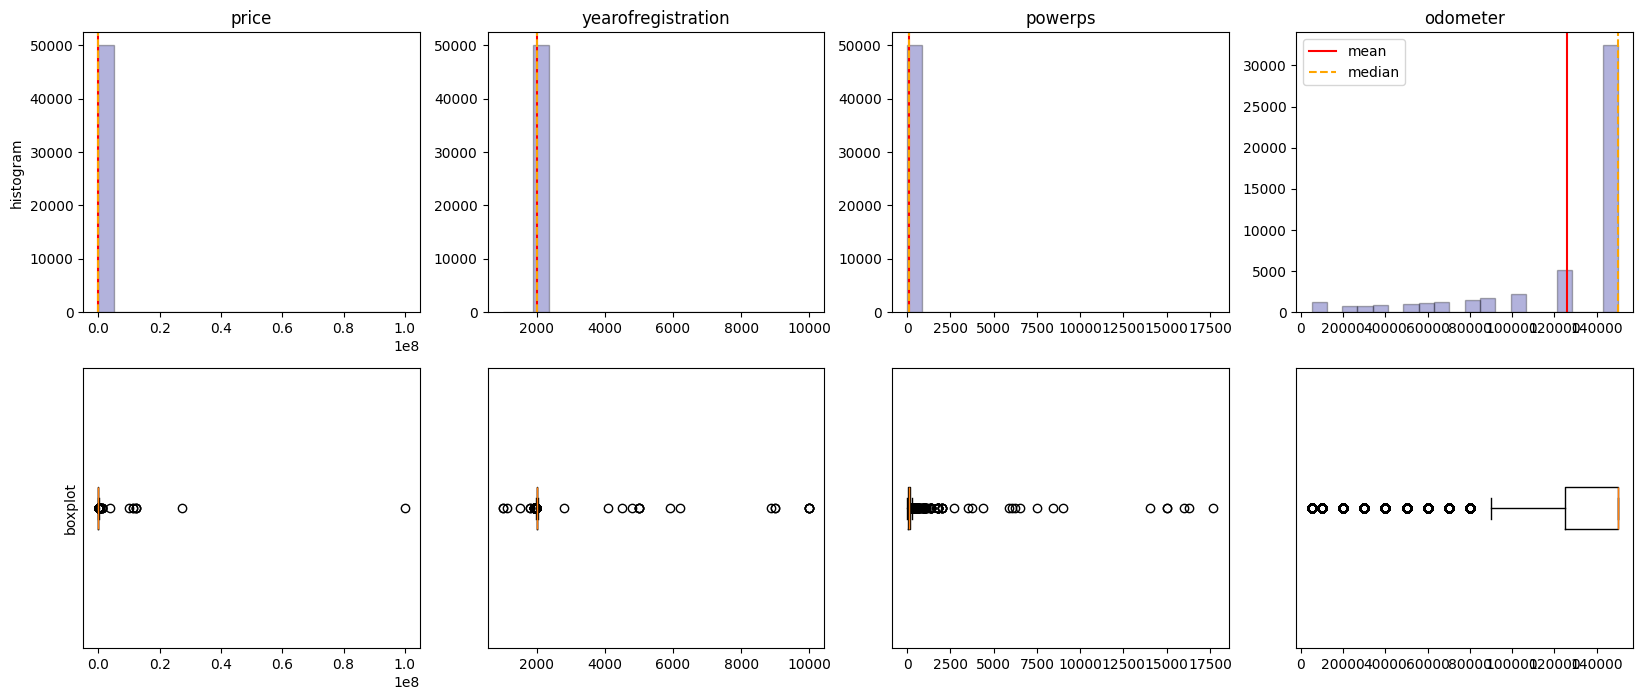

In [45]:
# визуализируем распределение числовых переменных
show_distribution(df_2, numerics)

Видим, что больше всех выделяется показатель odometer (пробег). Далее проанализируем почему так.

In [46]:
# напишем функцию для работы метода межквартильного размаха
def outliers_iqr(data, feature):
    x = data[feature]
    # вычисляем квартили
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    # вычисляем межквартильное расстояние
    iqr = quartile_3 - quartile_1
    # вычисляем границы Тьюки
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    # обозначаем выбросы и очищенные данные, это же и выводим
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [47]:
outliers, cleaned = outliers_iqr(df_2, 'price')
print(f'Число выбросов по признаку "price" по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по признаку "price" по методу Тьюки: 3784
Результирующее число записей: 46207


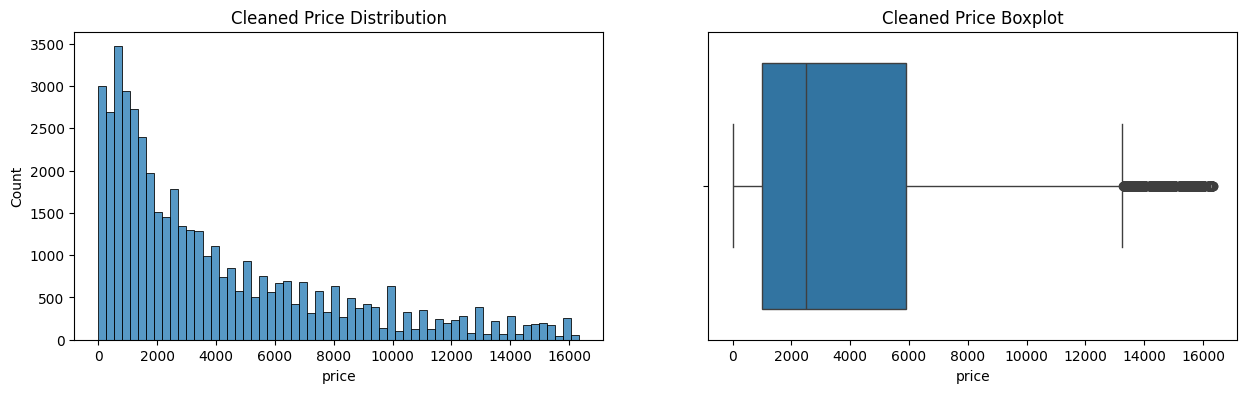

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='price', ax=axes[0]);
histplot.set_title('Cleaned Price Distribution');
boxplot = sns.boxplot(data=cleaned, x='price', ax=axes[1]);
boxplot.set_title('Cleaned Price Boxplot');

In [49]:
outliers, cleaned = outliers_iqr(df_2, 'yearofregistration')
print(f'Число выбросов по признаку "yearofregistration" по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по признаку "yearofregistration" по методу Тьюки: 942
Результирующее число записей: 49058


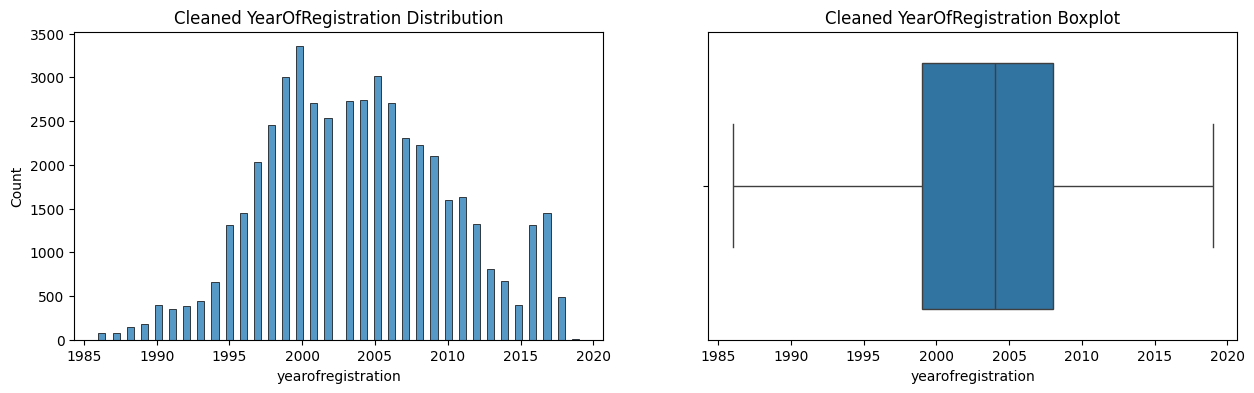

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='yearofregistration', ax=axes[0]);
histplot.set_title('Cleaned YearOfRegistration Distribution');
boxplot = sns.boxplot(data=cleaned, x='yearofregistration', ax=axes[1]);
boxplot.set_title('Cleaned YearOfRegistration Boxplot');

In [51]:
outliers, cleaned = outliers_iqr(df_2, 'powerps')
print(f'Число выбросов по признаку "powerps" по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по признаку "powerps" по методу Тьюки: 1461
Результирующее число записей: 48533


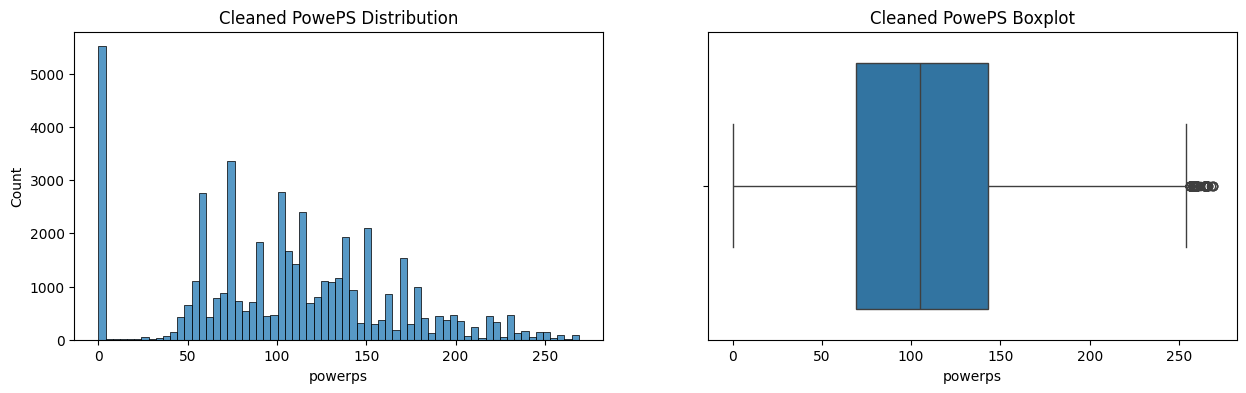

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='powerps', ax=axes[0]);
histplot.set_title('Cleaned PowePS Distribution');
boxplot = sns.boxplot(data=cleaned, x='powerps', ax=axes[1]);
boxplot.set_title('Cleaned PowePS Boxplot');

По графику видно, что у показателя Мощность Двигателя много нулевых значений (что нелогично). Это некорректные значения, которые надо исправить. Наиболее правильно будет заменить их на медианную величину.

In [53]:
powerPS_med = cleaned['powerps'].median()
cleaned['powerps'].replace(0, powerPS_med, inplace=True)

/var/folders/50/18ts1bh12532xjz2xv95cl540000gn/T/ipykernel_77545/91417462.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned['powerps'].replace(0, powerPS_med, inplace=True)
/var/folders/50/18ts1bh12532xjz2xv95cl540000gn/T/ipykernel_77545/91417462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['powerps'].replace(0, powerP

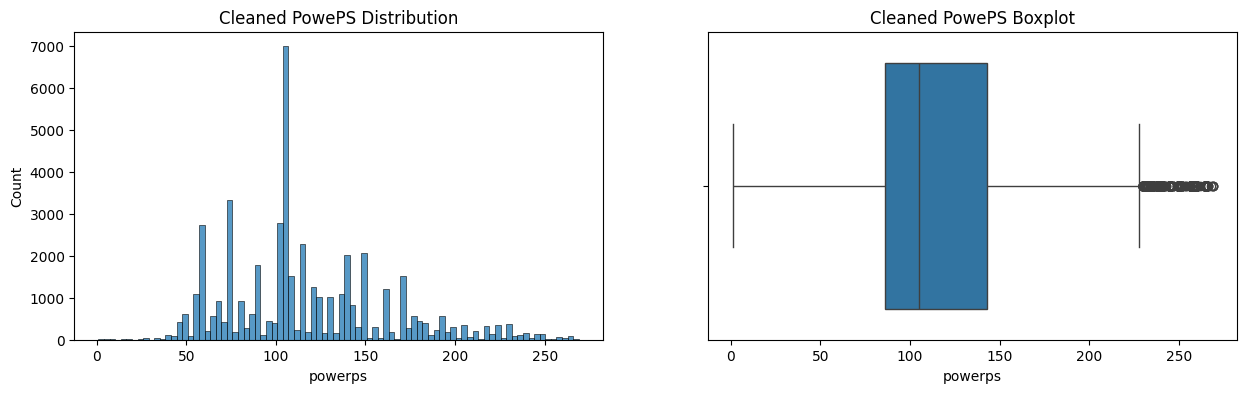

In [54]:
# повторим построение графиков

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='powerps', ax=axes[0]);
histplot.set_title('Cleaned PowePS Distribution');
boxplot = sns.boxplot(data=cleaned, x='powerps', ax=axes[1]);
boxplot.set_title('Cleaned PowePS Boxplot');

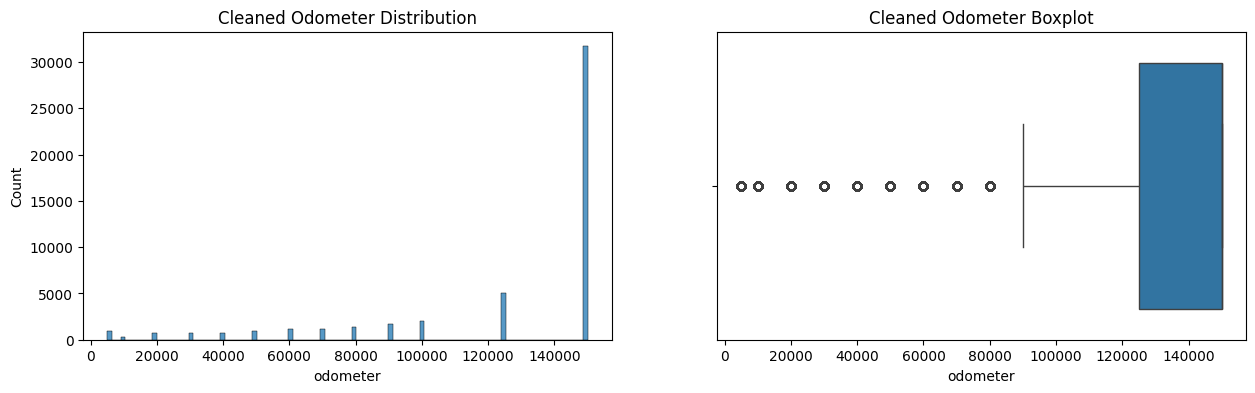

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='odometer', ax=axes[0]);
histplot.set_title('Cleaned Odometer Distribution');
boxplot = sns.boxplot(data=cleaned, x='odometer', ax=axes[1]);
boxplot.set_title('Cleaned Odometer Boxplot');

Основываясь на том, что пробег у подержаной машины может быть любым (в пределах разумного), можно сделать вывод, что значения на графике не являются выбросами (тем более они расположены примерно через одинаковый интервал друг от друга) и их не нужно корректировать.